![Eigenfaces](eigenfaces.png)

# Caracteristiques Propres

Objectifs :

- Apprendre à extraire des caractéristiques plus abstraites sur des images de façon semi-automatique
- Mélanger les approches d'entrainement non-supervisé et supervisé

## Partie 1 : recherche d'information

- Qu'est-ce que la méthode _Eigenface_ en vision par ordinateur ?
- Quelles sont les applications concrètes de cette méthode ?
- Quel algorithme non-supervisé est utilisé par cette méthode ?
- Que signifie le terme _eigen_ ?

## Partie 2 : reconnaissance de visages

Nous allons mettre en pratique la méthode de _Eigenface_ (ou _visage propre_) pour reproduire son utilisation historique :
la reconnaissance de visages. Cette problématique rentre dans la catégorie de classification multi-classe.

Un jeu de données iconique pour cette application est le ["Labeled Faces in the Wild" ("LFW")](http://vis-www.cs.umass.edu/lfw/).

La bibliothèque Scikit-Learn permet d'utiliser le
[jeu de données](https://scikit-learn.org/stable/datasets/real_world.html#labeled-faces-in-the-wild-dataset)
directement.

Etapes :

1. Extraire le jeu de données LFW (utiliser `min_faces_per_person=70` pour réduire le nombre de classes)
2. Effectuer une analyse de données exploratoire
3. Afficher un exemple d'image de chaque classe
4. Normaliser les features du jeu de données
5. Entrainer et évaluer un classifieur de régression logistique sur les images brutes
6. Entrainer et pré-traiter les images avec la méthode _Eigenface_
7. Afficher les 10 premiers masques _Eigenfaces_ signifiants
8. Entrainer et évaluer un classifieur de régression logistique sur les _Eigenfaces_
9. Afficher 10 images bien classifiées et 10 images mal classifiées
10. Conclure

Note : un [exemple](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)
de la communauté Scikit-Learn implémente la méthode Eigenface sur LFW.

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Extraction du jeu de données LFW :

In [43]:
def extract_dataset():
    lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
    return lfw_people.data, lfw_people.target, lfw_people.images, lfw_people.target_names

X, y, images, class_names = extract_dataset()
n_samples, h, w = images.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
class_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

Rapide analyse exploratoire de répartition des classes :

In [44]:
y_train_df = pd.DataFrame(data=y)
y_train_df.astype('object').describe()

0
count   1288
unique     7
top        3
freq     530

<AxesSubplot:xlabel='0'>

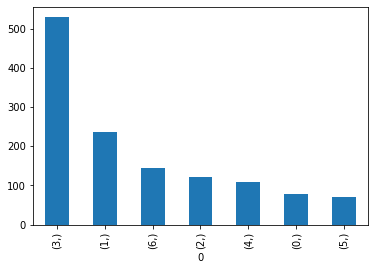

In [45]:
y_train_df.value_counts().plot.bar()

Affichage d'une image de chacune des 7 classes :

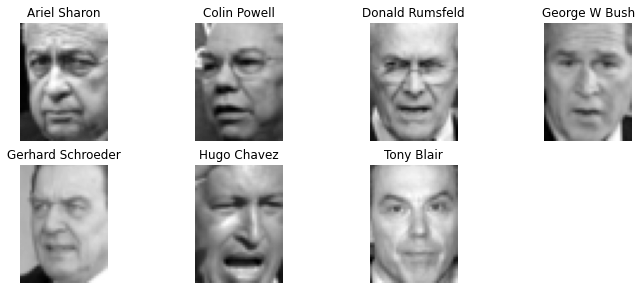

In [46]:
plt.figure(figsize=(12, 10))
for i in range(7):
    idx = np.where(y_train == i)[0][0]
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[idx].reshape((h, w)), cmap="gray")
    plt.title(class_names[i])
    plt.axis("off")

Entrainement d'un classifieur régression logistique sur le images brutes :

In [47]:
clf_raw = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(random_state=0, max_iter=10000)),
    ]
)

clf_raw.fit(X_train, y_train)
raw_y_pred = clf_raw.predict(X_test)

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.79      0.80        28
     Colin Powell       0.85      0.84      0.85        63
  Donald Rumsfeld       0.65      0.71      0.68        24
    George W Bush       0.87      0.89      0.88       132
Gerhard Schroeder       0.68      0.65      0.67        20
      Hugo Chavez       0.94      0.68      0.79        22
       Tony Blair       0.79      0.91      0.85        33

         accuracy                           0.83       322
        macro avg       0.80      0.78      0.79       322
     weighted avg       0.83      0.83      0.83       322



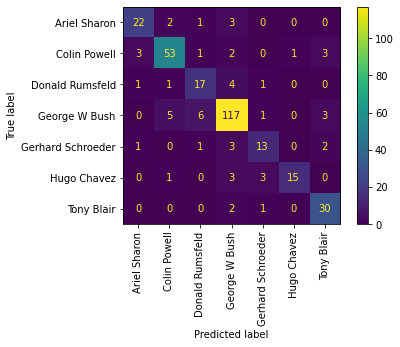

In [48]:
_ = ConfusionMatrixDisplay.from_predictions(
    y_test,
    raw_y_pred,
    display_labels=class_names,
    xticks_rotation="vertical",
)

print(classification_report(y_test, raw_y_pred, target_names=class_names))

Entrainement d'un classifieur régression logistique à partir des Eigenfaces (transformation par PCA en amont) :

In [49]:
n_components = 200
clf_eigen = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components)),
        ("classifier", LogisticRegression(random_state=0, max_iter=10000)),
    ]
)

clf_eigen.fit(X_train, y_train)
eigen_y_pred = clf_eigen.predict(X_test)

                   precision    recall  f1-score   support

     Ariel Sharon       0.84      0.75      0.79        28
     Colin Powell       0.83      0.83      0.83        63
  Donald Rumsfeld       0.61      0.71      0.65        24
    George W Bush       0.88      0.89      0.88       132
Gerhard Schroeder       0.71      0.75      0.73        20
      Hugo Chavez       0.94      0.68      0.79        22
       Tony Blair       0.81      0.88      0.84        33

         accuracy                           0.83       322
        macro avg       0.80      0.78      0.79       322
     weighted avg       0.83      0.83      0.83       322



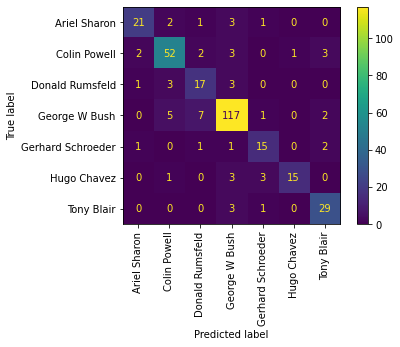

In [50]:
_ = ConfusionMatrixDisplay.from_predictions(
    y_test,
    eigen_y_pred,
    display_labels=class_names,
    xticks_rotation="vertical",
)

print(classification_report(y_test, eigen_y_pred, target_names=class_names))

Affichage des 10 premiers masques Eigenface (i.e. 10 premiers composants principaux de la PCA) :

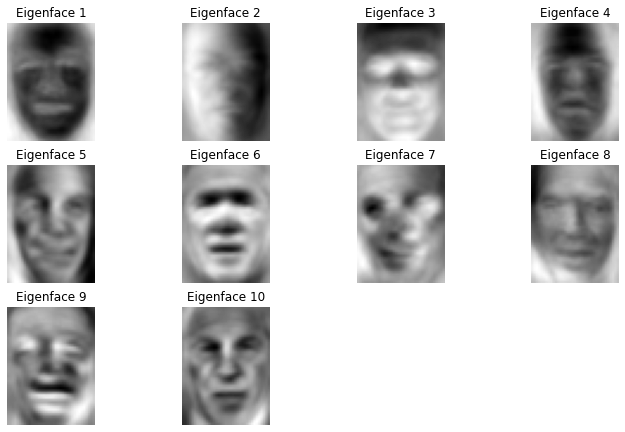

In [51]:
eigenfaces = clf_eigen["pca"].components_.reshape((n_components, h, w))
plt.figure(figsize=(12, 10))
for i in range(10):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(eigenfaces[i,:,:], cmap="gray")
    plt.title(f"Eigenface {i + 1}")
    plt.axis("off")

Affichage de 10 images correctement classifiées :

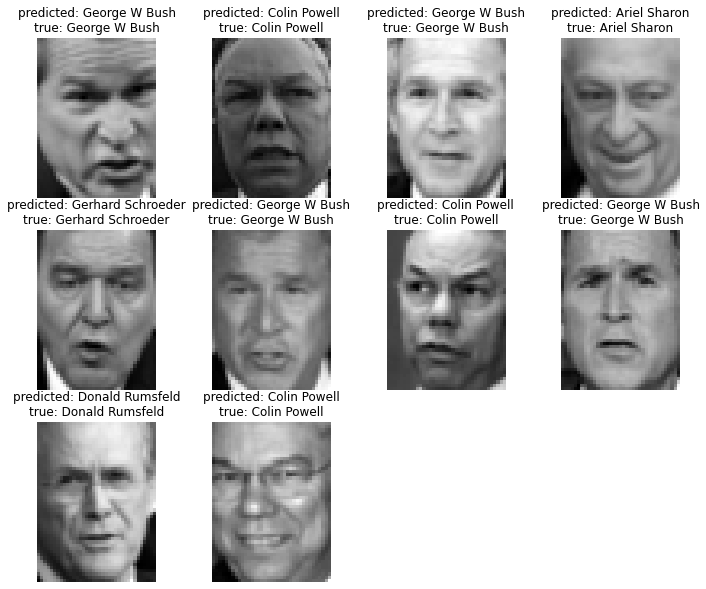

In [52]:

plt.figure(figsize=(12, 10))
for i in range(10):
    idx = np.where(y_test == eigen_y_pred)[0][i]
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[idx].reshape((h, w)), cmap="gray")
    plt.title(f"predicted: {class_names[eigen_y_pred[idx]]}\ntrue: {class_names[y_test[idx]]}")
    plt.axis("off")

Affichage de 10 images mal classifiées :

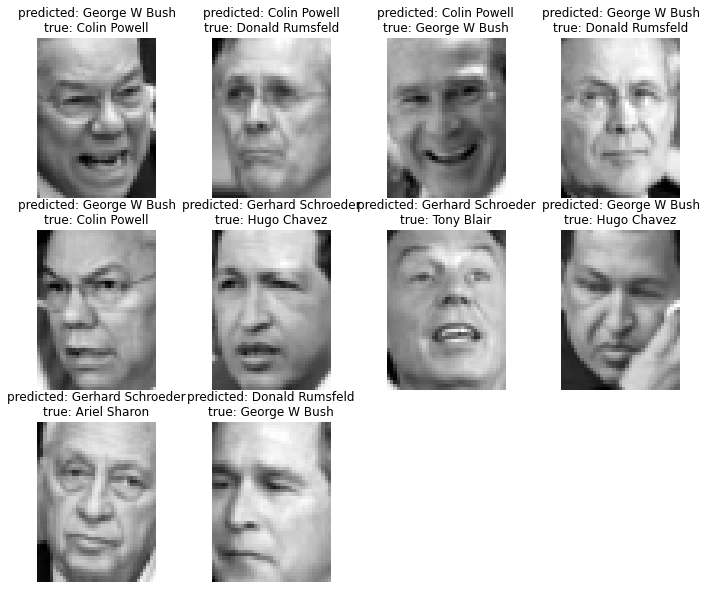

In [53]:

plt.figure(figsize=(12, 10))
for i in range(10):
    idx = np.where(y_test != eigen_y_pred)[0][i]
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[idx].reshape((h, w)), cmap="gray")
    plt.title(f"predicted: {class_names[eigen_y_pred[idx]]}\ntrue: {class_names[y_test[idx]]}")
    plt.axis("off")

## Partie 3 : reconnaissance de caractères

- Appliquer la même méthodologie _Eigenfaces_ qu'à la partie 2 avec le jeu de données MNIST
- Evaluer la performance de classification par rapport aux méthodes d'ingénierie des caractéristiques manuelles effectuées précédemment

Note : un [exemple](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html) de la communauté Scikit-Learn implémente la réduction de dimension PCA pour l'extraction de feature automatique sur MNIST.

In [54]:
# YOUR CODE HERE

## Partie 4 : modèle naïf sans apprentissage machine

Challenge : en ré-utilisant soit les visages du jeu "LFW" soit les digits du jeu "MNIST" et sans effectuer d'ingénierie des caractéristiques, pouvez-vous trouver un modèle **sans apprentissage machine** permettant de classifier avec une précision meilleure qu'un classifieur _dummy_ ?

In [55]:
# YOUR CODE HERE